# Generate the `doctors` dataset

#### Variables
- `permit`: a unique identifier for each doctor (free-form text)
- `name`: the doctor's name (free-form text)
- `loc`: the location where the doctor lives (`rur` for rural or `urb` for urban)
- `work`: workplace type (`hos` for hospital, `cli` for clinic, or `eld` for elderly home)
- `age`: age (numeric; integer)
- `exp`: years of experience (numeric)
- `hours`: total work hours per week (numeric)
- `caf`: caffeine consumption per week (numeric)
- `alc`: alcohol consumption in standard drinks per week (numeric)
- `weed`: marijuana consumption in grams per week (numeric)
- `exrc`: total time dedicated to exercise per week (numeric)
- `score`: sleep score outcome variable (numeric; integer)

Other ideas of variables I could add later on:
- `fam`: family status (`single`, `married`)
- `kids`: number of children (numeric; integer)
- `stress`: level of work-related stress (numeric)
- `cigs`: number cigarettes smoked per week (numeric; integer)
- `bmi`: body mass index (numeric)
- `meds`: medications taken regularly (free-form text)


#### Main use cases
- Sec 4.1 Simple linear regression exercise `sleep ~ 1 + alc`
- Sec 4.2 Multiple linear regression running exercise
    - `sleep ~ 1 + alc + weed + exrc`
- Sec 4.3 Fit metrics, CIs, hypothesis tests, and diagnostic checks
- Sec 4.4 Linear regression with categorical predictor
  - Example 1: `sleep ~ C(loc)` (binary)
  - Example 2: `sleep ~ C(work)` (three levels)
  - Example 3: `sleep ~ 1 + C(loc) + alc` (mix of categorical and numerical predictors)

#### Auxiliary use cases
- Sec 3.1 Used in `dmeans` estimator exercises
- Sec 3.2 Used in CI exercises
- Sec 3.5 Used in hypothesis testing exercises

In [1]:
datafilepath = "../datasets/doctors.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from faker import Faker
faker = Faker()

In [4]:
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import expon
from scipy.stats import randint

## Dataset design choices


In order to give give an example of a group-dependent slope,
we'll make 

In [5]:
# Number of samples
n = 156

# Proportion of Rural locations
prop_rural = 0.3

# Proportion of Hospital and Clinic workplacs
prop_hopital = 0.27
prop_clinic = 0.57

# Standard deviation of the error term
sigma = 5

## Generate names

In [6]:
faker.unique.clear()
faker.seed_instance(301)
names = [faker.unique.name() for _ in range(0,n)]

assert len(set(names)) == len(names), "names should be unique"
names[0:5]

['Robert Snyder',
 'David Barnett',
 'Wesley Sanchez',
 'Anna Griffin',
 'Tiffany Richard']

## Generate permit numbers

In [7]:
faker.unique.clear()
faker.seed_instance(302)
permits = [faker.unique.random_int(min=20202, max=100110) for _ in range(0,n)]

assert len(set(permits)) == len(permits), "permits should be unique"
permits[0:5]

[93273, 90852, 92744, 73553, 82441]

## Generate locations

In [8]:
nR = int(n * prop_rural)
nU = n - nR
assert nR + nU == n

np.random.seed(36)
locations = np.random.permutation(["rur"]*nR + ["urb"]*nU)
locations[0:5]

array(['rur', 'urb', 'urb', 'urb', 'rur'], dtype='<U3')

## Generate workplaces

In [9]:
nH = int(n * prop_hopital)
nC = int(n * prop_clinic)
nE = n - nH - nC
assert nH + nC + nE == n

np.random.seed(32)
workplaces = np.random.permutation(["hos"]*nH + ["cli"]*nC + ["eld"]*nE)
workplaces[0:5]

array(['hos', 'cli', 'hos', 'eld', 'cli'], dtype='<U3')

## Generate ages and experience

In [10]:
np.random.seed(48)
ages = randint(26, 65).rvs(n)

np.random.seed(49)
grad_ages = np.zeros_like(ages)
for i, age in enumerate(ages):
    grad_age = randint(24, 35).rvs(1)
    if grad_age >= age:
        grad_age = age - randint(1,5).rvs(1)
    grad_ages[i] = grad_age

experiences = ages - grad_ages
list(zip(ages, experiences))[0:5]

/var/folders/wc/2r44j8gs4gn56t1xtw5f6wlm0000gn/T/ipykernel_70176/2581071922.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_ages[i] = grad_age


[(26, 2), (43, 11), (30, 1), (53, 23), (26, 3)]

## Generate work hours

In [11]:
from ministats.probs import MixtureModel

rvHours = MixtureModel([uniform(20, 60), uniform(35, 30)])
# xs = np.linspace(0, 100)
# sns.lineplot(x=xs, y=rvHours.pdf(xs))

np.random.seed(50)
hours = rvHours.rvs(n).astype(int)
hours[0:5]

array([21, 74, 63, 77, 36])

## Generate caffeine consumption

In [12]:
np.random.seed(51)

# caffeine consumption partially dependent on number of hours worked
hours_cups = 15/50*hours
random_cups = MixtureModel([uniform(-6,19),uniform(-4,10)],weights=[0.8,0.2]).rvs(n)
cups = hours_cups + random_cups

# 10% of population don't drink coffee
coins = np.random.random(n)
caffeines = np.where(coins<0.1, 0, cups)

caffeines = caffeines.astype(int)
caffeines[0:5]
# sns.histplot(caffeines, bins=30)

array([ 2, 26, 25, 36, 22])

## Generate alcohol consumption

In [13]:
# Assuming 0 to 20 drinks per week
rvAlcohol = MixtureModel([ randint(0,1),   uniform(0, 20),  expon(loc=18, scale=7)],
                          weights=[0.15,    0.6,             0.25])

np.random.seed(55)
alcohols = rvAlcohol.rvs(n)
alcohols = alcohols.astype(int)
# sns.histplot(alcohols, bins=max(alcohols))
alcohols[0:5]

array([ 0, 20,  1,  4,  9])

## Generate cannabis consumption

In [14]:
# Assuming 0 to 10 grams per week
rvWeed = MixtureModel([randint(0,1), uniform(0,3), expon(loc=0,scale=2.5)],
              weights=[0.7,          0.2,          0.1])

np.random.seed(56)
weeds = rvWeed.rvs(n)
weeds = np.round(2*weeds)/2  # round to nearest 0.5
# sns.histplot(weeds, bins=int(max(weeds))) 
weeds[0:5]

array([5., 0., 0., 0., 0.])

## Generate exercise

In [15]:
rvExercise = MixtureModel([randint(0,1), uniform(0,10), uniform(6,14)],
                          weights=[0.2,  0.6,           0.2])

np.random.seed(57)
exercises = rvExercise.rvs(n)

exercises = np.round(2*exercises)/2  # round to nearest 0.5
# sns.histplot(exercises, bins=int(max(exercises))) 
exercises[0:5]

array([0. , 4.5, 7. , 2. , 7.5])

## Create the data frame all the exogenous variables

In [16]:
# Generate synthetic data
df = pd.DataFrame({
    'permit': permits,
    'name': names,
    'loc': locations,
    'work': workplaces,
    'age': ages,
    'exp': experiences,
    'hours': hours,
    'caf': caffeines,
    'alc': alcohols,
    'weed': weeds,
    'exrc': exercises,
})
# df

## Generate sleep scores

In [17]:
# Error term
np.random.seed(62)
noise = norm(loc=0, scale=sigma).rvs(n)

# Catagorical effects
loc_map = {'urb': 0,
           'rur': 1}

work_map = {"cli": 1.0,
            "eld": 2.0,
            "hos": 2.2}


# Score as a linear combination mixture of the predictors
df['score'] = (
    58                                # Base score
    +   5 * df['loc'].map(loc_map)    # Big difference for location
    +   3 * df['work'].map(work_map)  # Medium difference for workplace type
    + 0.5 * df['exp']                 # Small positive effect for experience
    - 0.2 * df['hours']               # Small negative effect for hours
    - 0.2 * df['caf']                 # Small negative effect for caffeine
    - 1.8 * df['alc']                 # Strong negative effect for alcohol
    - 0.5 * df['weed']                # Small negative effect for weed
    + 1.9 * df['exrc']                # Strong positive effect for exercise
    + noise  # Gaussian noise
)

# Convert score to integer
df['score'] = df['score'].round().astype(int)

# Manual fix for Jasmine
print("Manually setting score for thef following people to avoid negative scores")
pd.set_option('display.width', 100)
print(df[df["score"]<0])
df.loc[df["score"]<0,"score"] = 4

doctors = df.copy()

print(doctors["score"].values[0:5])
doctors["score"].describe()

Manually setting score for thef following people to avoid negative scores
    permit           name  loc work  age  exp  hours  caf  alc  weed  exrc  score
36   74619  Jasmine Lynch  urb  cli   47   14     56   26   42   0.0   2.5    -15
[63 16 58 55 47]


count    156.000000
mean      48.025641
std       20.446294
min        4.000000
25%       33.000000
50%       49.500000
75%       62.000000
max       97.000000
Name: score, dtype: float64

## Score range checks

In [18]:
doctors[doctors["score"]>100]

,permit,name,loc,work,age,exp,hours,caf,alc,weed,exrc,score


In [19]:
doctors[doctors["score"]<=0]

,permit,name,loc,work,age,exp,hours,caf,alc,weed,exrc,score


In [20]:
# # Make sure scores don't exceed 100
assert doctors['score'].max() <= 100
assert doctors['score'].min() > 0

In [21]:
## Save data file

In [22]:
# SAVE TO DATAFILE
doctors.to_csv(datafilepath, index=False)

In [23]:
# # RELOAD FROM DATAFILE
# doctors = pd.read_csv(datafilepath)
# doctors.head()

In [24]:
doctors.head()

,permit,name,loc,work,age,exp,hours,caf,alc,weed,exrc,score
0,93273,Robert Snyder,rur,hos,26,2,21,2,0,5.0,0.0,63
1,90852,David Barnett,urb,cli,43,11,74,26,20,0.0,4.5,16
2,92744,Wesley Sanchez,urb,hos,30,1,63,25,1,0.0,7.0,58
3,73553,Anna Griffin,urb,eld,53,23,77,36,4,0.0,2.0,55
4,82441,Tiffany Richard,rur,cli,26,3,36,22,9,0.0,7.5,47


## Tests for difference between rural and urban

### Visual inspection

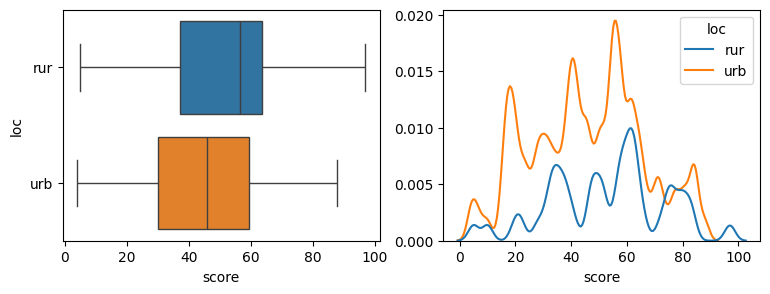

In [25]:
with plt.rc_context({"figure.figsize":(9,3)}):
    fig, (ax1,ax2) = plt.subplots(1,2)
    sns.boxplot(x="score", y="loc", hue="loc", data=doctors, ax=ax1)
    sns.kdeplot(x="score", hue="loc", data=doctors, bw_adjust=0.2, ax=ax2)
    ax2.set_ylabel(None)

### Want the Welch t-test for `loc` to reject H0

In [26]:
from scipy.stats import ttest_ind

scoresR = doctors[doctors["loc"]=="rur"]["score"]
scoresU = doctors[doctors["loc"]=="urb"]["score"]
ttest_ind(scoresR, scoresU, equal_var=False).pvalue

0.05327318474001391

### ANOVA test for workplace to fail to reject H0

In [27]:
from scipy.stats import f_oneway

scoresH = doctors[doctors["work"]=="hos"]["score"]
scoresC = doctors[doctors["work"]=="cli"]["score"]
scoresE = doctors[doctors["work"]=="eld"]["score"]

f_oneway(scoresH, scoresC, scoresE)

F_onewayResult(statistic=0.5953116925291182, pvalue=0.5526627461285608)

### Confidence interval for dmeans

In [28]:
from ministats import ci_dmeans

ci_dmeans(scoresR, scoresU, method="b")
ci_dmeans(scoresR, scoresU)

[1.0599249117092784, 12.925845839278871]

## Linear regression plots

In [29]:
sns.regplot(data=doctors, x="alc", y="score", color="y")

<Axes: xlabel='alc', ylabel='score'>

In [30]:
sns.regplot(data=doctors, x="weed", y="score", color="g")

<Axes: xlabel='weed', ylabel='score'>

In [31]:
sns.regplot(data=doctors, x="caf", y="score", color="brown")

<Axes: xlabel='caf', ylabel='score'>